In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import h5py
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.utils import class_weight

In [ ]:
with h5py.File('/content/drive/MyDrive/Dataset/traindataset.h5', 'r') as hdf5_file:
    X_train_images_np = np.array(hdf5_file['X'][:])
    y_train_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/val.h5', 'r') as hdf5_file:
    X_val_images_np = np.array(hdf5_file['X'][:])
    y_val_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/testdataset.h5', 'r') as hdf5_file:
    X_test_images_np = np.array(hdf5_file['X'][:])
    y_test_labels_np = np.array(hdf5_file['Y'][:])

if X_train_images_np.ndim == 3:
    X_train_images_np = np.expand_dims(X_train_images_np, axis=-1)
if X_val_images_np.ndim == 3:
    X_val_images_np = np.expand_dims(X_val_images_np, axis=-1)
if X_test_images_np.ndim == 3:
    X_test_images_np = np.expand_dims(X_test_images_np, axis=-1)

print("Training set shape:", X_train_images_np.shape, y_train_labels_np.shape)
print("Validation set shape:", X_val_images_np.shape, y_val_labels_np.shape)
print("Test set shape:", X_test_images_np.shape, y_test_labels_np.shape)

Training set shape: (5187, 50, 50, 1) (5187, 2)
Validation set shape: (1297, 50, 50, 1) (1297, 2)
Test set shape: (1622, 50, 50, 1) (1622, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

In [ ]:
def create_model_2(input_shape=(50, 50, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

# Compile the model with Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_pred) - y_pred)
        fl = - alpha_t * tf.keras.backend.pow((tf.ones_like(y_true) - p_t), gamma) * tf.keras.backend.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

model_2 = create_model_2()
model_2.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Callbacks
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint_2 = ModelCheckpoint('best_model_2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Print Model Summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 64)        0         
 D)                                                              
                                                        

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Data generator for validation and test (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow(X_train_images_np, y_train_labels_np, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val_images_np, y_val_labels_np, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test_images_np, y_test_labels_np, batch_size=32, shuffle=False)

import tensorflow as tf

train_generator = train_datagen.flow(X_train_images_np, y_train_labels_np, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val_images_np, y_val_labels_np, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test_images_np, y_test_labels_np, batch_size=32, shuffle=False)

# Generator wrapper for single-input
def single_input_generator(generator):
    for X_batch, y_batch in generator:
        yield X_batch, y_batch

# Define output signature
output_signature = (
    tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
)

train_multi_generator = tf.data.Dataset.from_generator(
    lambda: single_input_generator(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
)

val_multi_generator = tf.data.Dataset.from_generator(
    lambda: single_input_generator(val_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
)


In [ ]:
# prompt: calculate the class weights of possitive and negative

import numpy as np
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels_np[:, 1]),
    y=y_train_labels_np[:, 1]
)

# Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.5973053892215568, 1: 3.0692307692307694}


In [ ]:
model_2 = create_model_2()
# Force eager execution for the focal loss function to prevent tf.function decoration
tf.config.run_functions_eagerly(True)
model_2.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
tf.config.run_functions_eagerly(False) # Reset to default graph mode
history = model_2.fit(
    train_multi_generator,
    steps_per_epoch=len(train_generator),
    epochs=500,
    validation_data=val_multi_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=[early_stopping_2, model_checkpoint_2, reduce_lr_2],
    verbose=1
)


Epoch 1/500
163/163 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.6885
Epoch 1: val_accuracy improved from -inf to 0.82729, saving model to best_model_2.keras
163/163 [==============================] - 40s 223ms/step - loss: 0.1948 - accuracy: 0.6885 - val_loss: 0.1884 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 2/500
163/163 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.7546
Epoch 2: val_accuracy did not improve from 0.82729
163/163 [==============================] - 35s 218ms/step - loss: 0.1055 - accuracy: 0.7546 - val_loss: 0.1905 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 3/500
163/163 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.7904
Epoch 3: val_accuracy did not improve from 0.82729
163/163 [==============================] - 35s 214ms/step - loss: 0.0709 - accuracy: 0.7904 - val_loss: 0.0790 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/500
163/163 [==============================] - ETA: 0s - loss: 0.0610 

In [ ]:
test_loss, test_acc = model_2.evaluate(test_generator, steps=len(test_generator))
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

51/51 [==============================] - 2s 39ms/step - loss: 0.0185 - accuracy: 0.9476
Test loss: 0.0185, Test accuracy: 0.9476


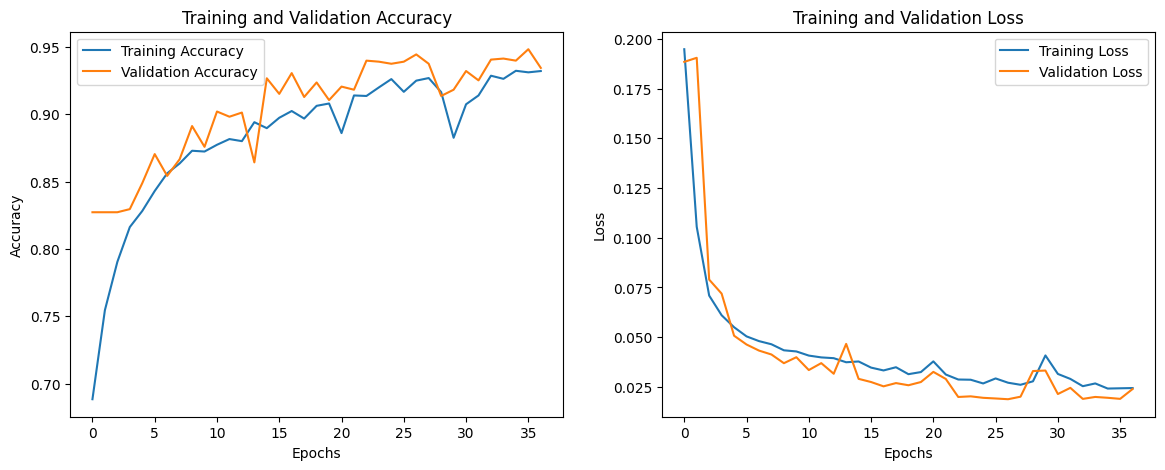

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# prompt: save the above model

model_2.save('/content/drive/MyDrive/Dataset/improved_model_2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 2s 40ms/step


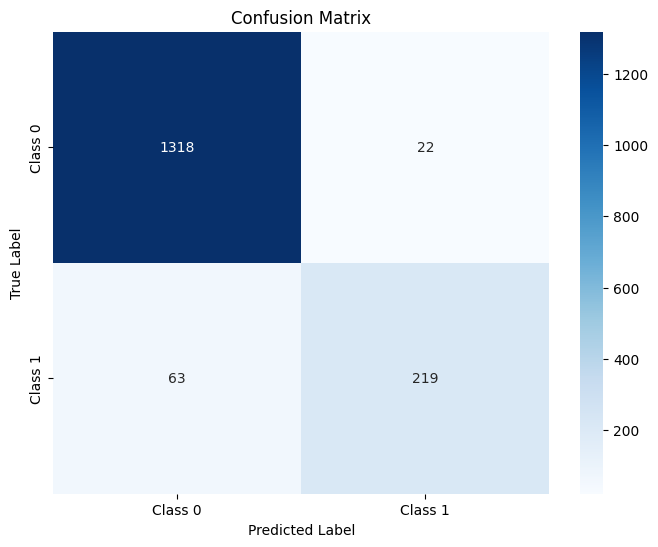

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1340
           1       0.91      0.78      0.84       282

    accuracy                           0.95      1622
   macro avg       0.93      0.88      0.90      1622
weighted avg       0.95      0.95      0.95      1622



In [ ]:
# prompt: plot the confusion matrix  and classification report for the above model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test data
y_pred_prob = model_2.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_labels_np, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred))


In [ ]:
# prompt: print the testdatalabels.txt where label is 1

import pandas as pd
# Read the dataset file
data = pd.read_csv('/content/drive/MyDrive/Dataset/testdatalabels.txt', delimiter=' ', header=None, names=['filename', 'label'])

# Filter the data where label is 1
filtered_data_1 = data[data['label'] == 1]
filtered_data_0 = data[data['label'] == 0]

# Print the filtered data
print(filtered_data_1)
print(filtered_data_0)

                   filename  label
3     test/image_441280.jpg      1
5     test/image_315896.jpg      1
8     test/image_179650.jpg      1
25    test/image_379773.jpg      1
26    test/image_353297.jpg      1
...                     ...    ...
1582  test/image_242899.jpg      1
1588   test/image_32118.jpg      1
1596  test/image_169613.jpg      1
1603  test/image_124632.jpg      1
1611  test/image_461441.jpg      1

[282 rows x 2 columns]
                   filename  label
0     test/image_189342.jpg      0
1     test/image_145102.jpg      0
2      test/image_31546.jpg      0
4     test/image_215578.jpg      0
6     test/image_159055.jpg      0
...                     ...    ...
1617   test/image_87015.jpg      0
1618  test/image_245189.jpg      0
1619  test/image_533231.jpg      0
1620   test/image_52755.jpg      0
1621  test/image_379730.jpg      0

[1340 rows x 2 columns]


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

# Create stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
for train_index, val_index in skf.split(X_train_images_np, np.argmax(y_train_labels_np, axis=1)):
    X_train_fold, X_val_fold = X_train_images_np[train_index], X_train_images_np[val_index]
    y_train_fold, y_val_fold = y_train_labels_np[train_index], y_train_labels_np[val_index]

    # Train and evaluate model on each fold
    model_2 = create_model_2()  # Recreate model for each fold
    model_2.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    model_2.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10)
    score = model_2.evaluate(X_val_fold, y_val_fold)
    print(f'Fold Score: {score}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.6126 - loss: 0.3405 - val_accuracy: 0.4258 - val_loss: 0.3586
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7746 - loss: 0.1162 - val_accuracy: 0.8382 - val_loss: 0.1178
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7784 - loss: 0.0973 - val_accuracy: 0.8430 - val_loss: 0.0512
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8285 - loss: 0.0668 - val_accuracy: 0.8545 - val_loss: 0.0423
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8418 - loss: 0.0522 - val_accuracy: 0.8709 - val_loss: 0.0395
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8704 - loss: 0.0445 - val_accuracy: 0.8555 - val_loss: 0.0474
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8850 - loss: 0.0379 - val_accuracy: 0.8854 - val_loss: 0.0358
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9059 - loss: 0.0323 - val_a

In [ ]:
# prompt: i want to test the modle with the sample image without using argmax or by taking max value

import numpy as np
# Load the image
image_path = '/content/drive/MyDrive/Dataset/test/image_189342.jpg'  # Replace with your image path
img = Image.open(image_path).convert('L')  # Convert to grayscale

# Resize the image
img = img.resize((50, 50))

# Convert to numpy array
image_array = np.array(img)

# Add an extra dimension for the batch size and channels
image_array = np.expand_dims(image_array, axis=0)
image_array = np.expand_dims(image_array, axis=-1)

# Normalize the image
image_array = image_array / 255.0

# Make a prediction
prediction = model_2.predict(image_array)

# Extract softmax probabilities
print(prediction)
probabilities = prediction[0]
print(probabilities)
# Set a confidence threshold (e.g., 0.6)
threshold = 0.6

# Determine predicted class based on the threshold
if np.max(probabilities) >= threshold:
  predicted_class = np.where(probabilities == np.max(probabilities))[0][0]
  confidence = np.max(probabilities)
  print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")
else:
  print(f"Uncertain prediction. Probabilities: {probabilities}")

# Map the predicted class to a human-readable label
class_labels = ['No Cancer', 'Cancer']
if np.max(probabilities) >= threshold:
  print(f"The model predicts: {class_labels[predicted_class]}")
else:
  print("The model is uncertain about the prediction.")
print(np.argmax(probabilities))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.83731836 0.16268164]]
[0.83731836 0.16268164]
Predicted class: 0 with confidence 0.84
The model predicts: No Cancer
0
